In [28]:
import pandas_datareader as pdr
import pandas as pd
import datetime 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [29]:
dataset = pdr.get_data_yahoo('LKOH.ME', 
                          start=datetime.datetime(2015, 1, 1), 
                          end=datetime.datetime(2020, 5, 1))

In [30]:
dataset = dataset.reset_index()

In [62]:
dataset['Mean'] = (dataset['Low'] + dataset['High'])/2
dataset

,Date,High,Low,Open,Close,Volume,Adj Close,Mean
0,2015-01-05,2317.000000,2200.899902,2201.000000,2295.0,567928.0,1614.829468,2258.949951
1,2015-01-06,2376.000000,2281.500000,2290.100098,2345.0,811259.0,1650.010742,2328.750000
2,2015-01-08,2595.100098,2361.000000,2371.000000,2572.0,1100028.0,1809.734741,2478.050049
3,2015-01-09,2579.000000,2452.500000,2565.000000,2461.0,1204061.0,1731.631958,2515.750000
4,2015-01-12,2519.000000,2441.399902,2460.100098,2477.0,909352.0,1742.889771,2480.199951
...,...,...,...,...,...,...,...,...
1333,2020-04-24,4876.000000,4720.000000,4874.500000,4745.5,1849964.0,4745.500000,4798.000000
1334,2020-04-27,4790.000000,4620.000000,4745.000000,4650.0,1687755.0,4650.000000,4705.000000
1335,2020-04-28,4808.000000,4624.000000,4624.000000,4738.5,2736525.0,4738.500000,4716.000000
1336,2020-04-29,4940.000000,4750.000000,4779.000000,4897.0,2888562.0,4897.000000,4845.000000


In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
Date         1338 non-null datetime64[ns]
High         1338 non-null float64
Low          1338 non-null float64
Open         1338 non-null float64
Close        1338 non-null float64
Volume       1338 non-null float64
Adj Close    1338 non-null float64
Mean         1338 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 83.8 KB


In [35]:
steps=-1
dataset_for_prediction= dataset.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift(steps)
dataset_for_prediction.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,Mean,Actual
0,2015-01-05,2317.000000,2200.899902,2201.000000,2295.0,567928.0,1614.829468,2258.949951,2328.750000
1,2015-01-06,2376.000000,2281.500000,2290.100098,2345.0,811259.0,1650.010742,2328.750000,2478.050049
2,2015-01-08,2595.100098,2361.000000,2371.000000,2572.0,1100028.0,1809.734741,2478.050049,2515.750000


In [36]:
dataset_for_prediction=dataset_for_prediction.dropna()

Text(0.5, 1.0, 'LUKOIL Stock Value')

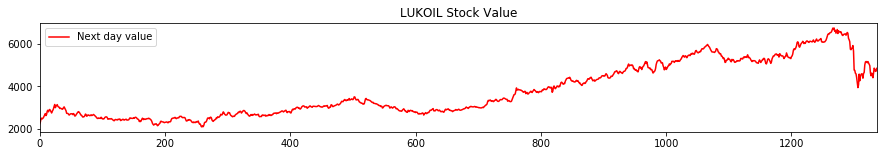

In [37]:
dataset_for_prediction['Mean'].plot(color='red', figsize=(15,2))
plt.legend(['Next day value', 'Mean'])
plt.title("LUKOIL Stock Value")

Text(0.5, 1.0, 'LUKOIL Stock Volume')

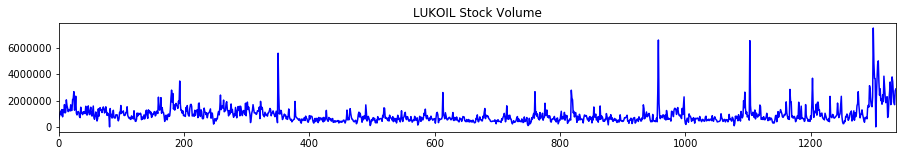

In [38]:
dataset_for_prediction['Volume'].plot(color='blue', figsize=(15,2))
plt.title("LUKOIL Stock Volume")

In [39]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High','Open', 'Close', 'Volume', 'Adj Close', 'Mean']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [40]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [41]:
X.rename(columns={0:'Low', 1:'High', 2:'Open', 3:'Close', 4:'Volume', 5:'Adj Close', 6:'Mean'}, inplace=True)
X.head(2)

,Low,High,Open,Close,Volume,Adj Close,Mean
0,0.034622,0.036457,0.028178,0.042650,0.075455,0.009677,0.032420
1,0.051977,0.049110,0.047344,0.053475,0.107783,0.016505,0.047516


In [42]:
y.rename(columns={0:'Stock Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
y.head(2)

,Stock Price next day
0,0.047516
1,0.079806


In [43]:
train_size=int(len(dataset) *0.7)
test_size = int(len(dataset)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

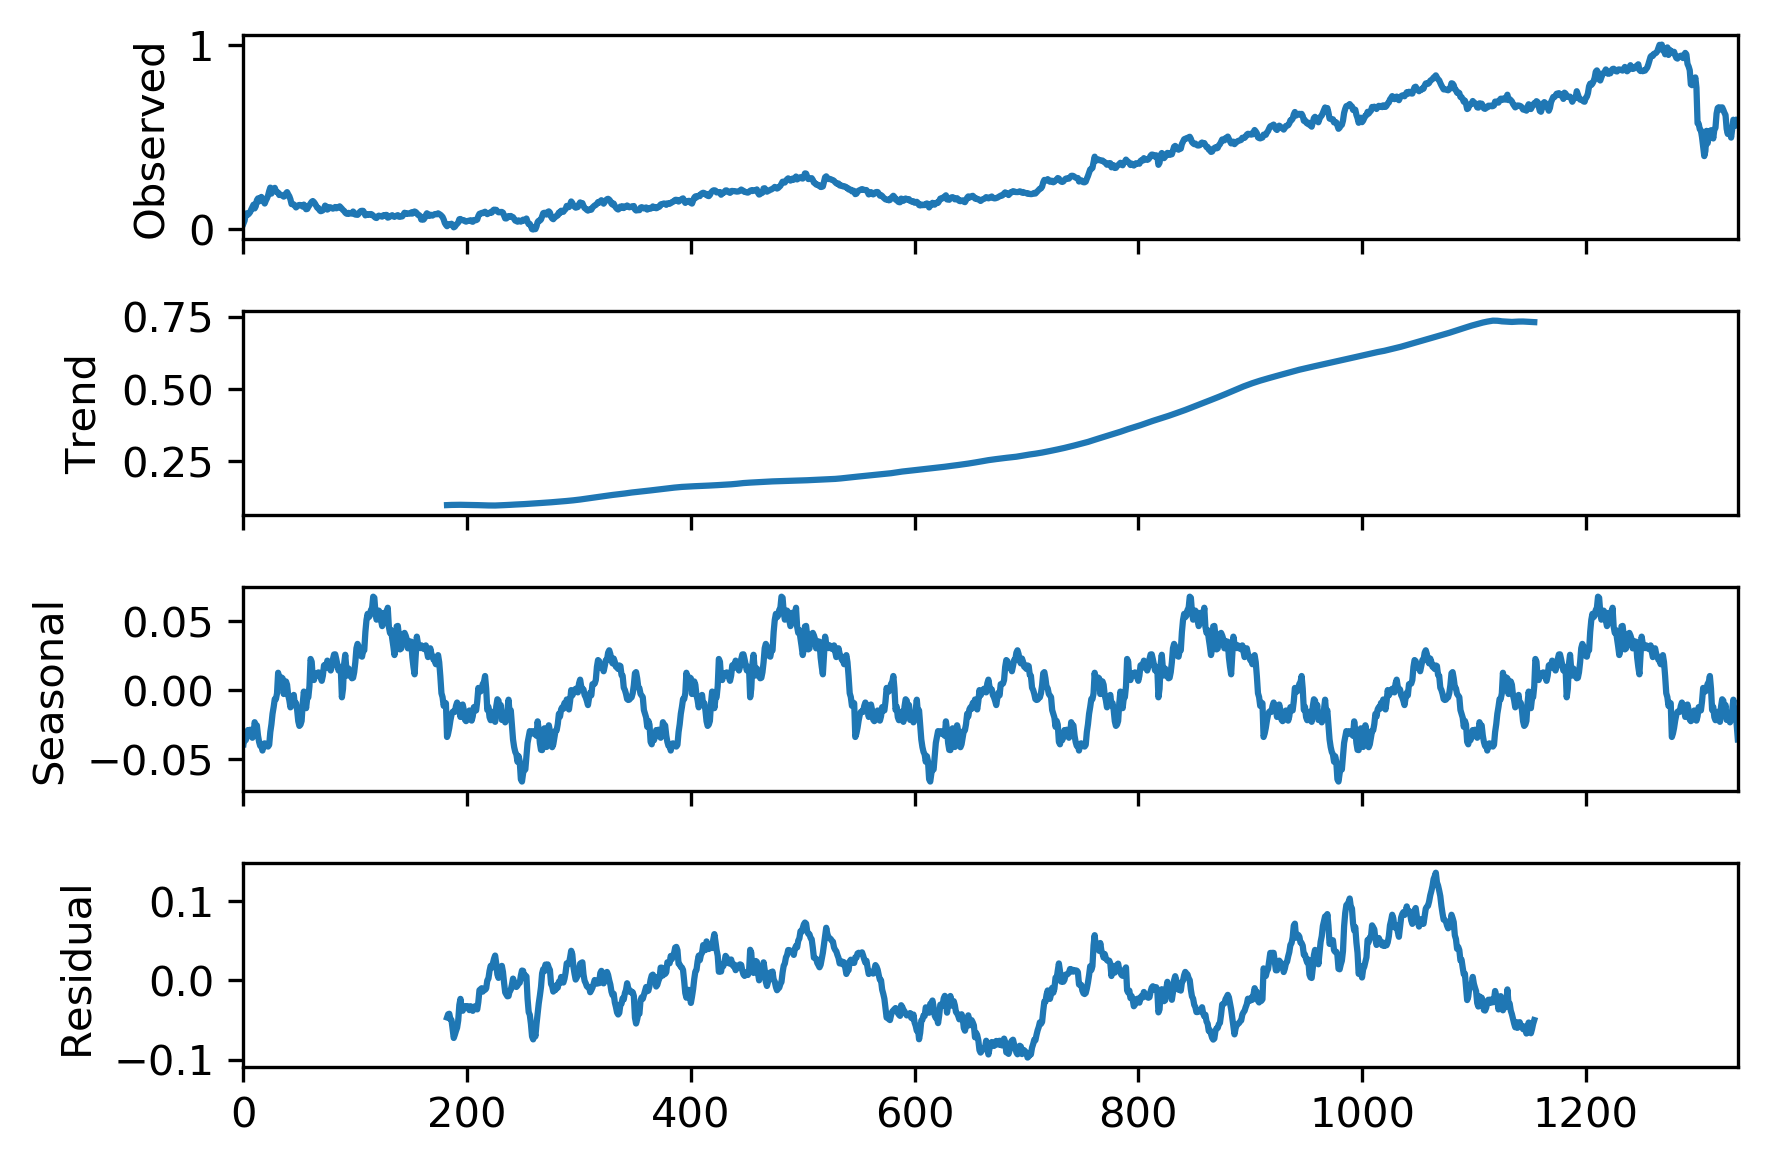

In [44]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(X['Mean'],model='add',freq=365);
fig=seas_d.plot()
fig.set_figheight(4)
fig.dpi=300
plt.show()

In [45]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [46]:
y_test=y['Stock Price next day'][:train_size].dropna()
test_adf(y_test, "Stock Price")

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Price


In [47]:
test_adf(y_test.diff(), "Stock Price")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Price


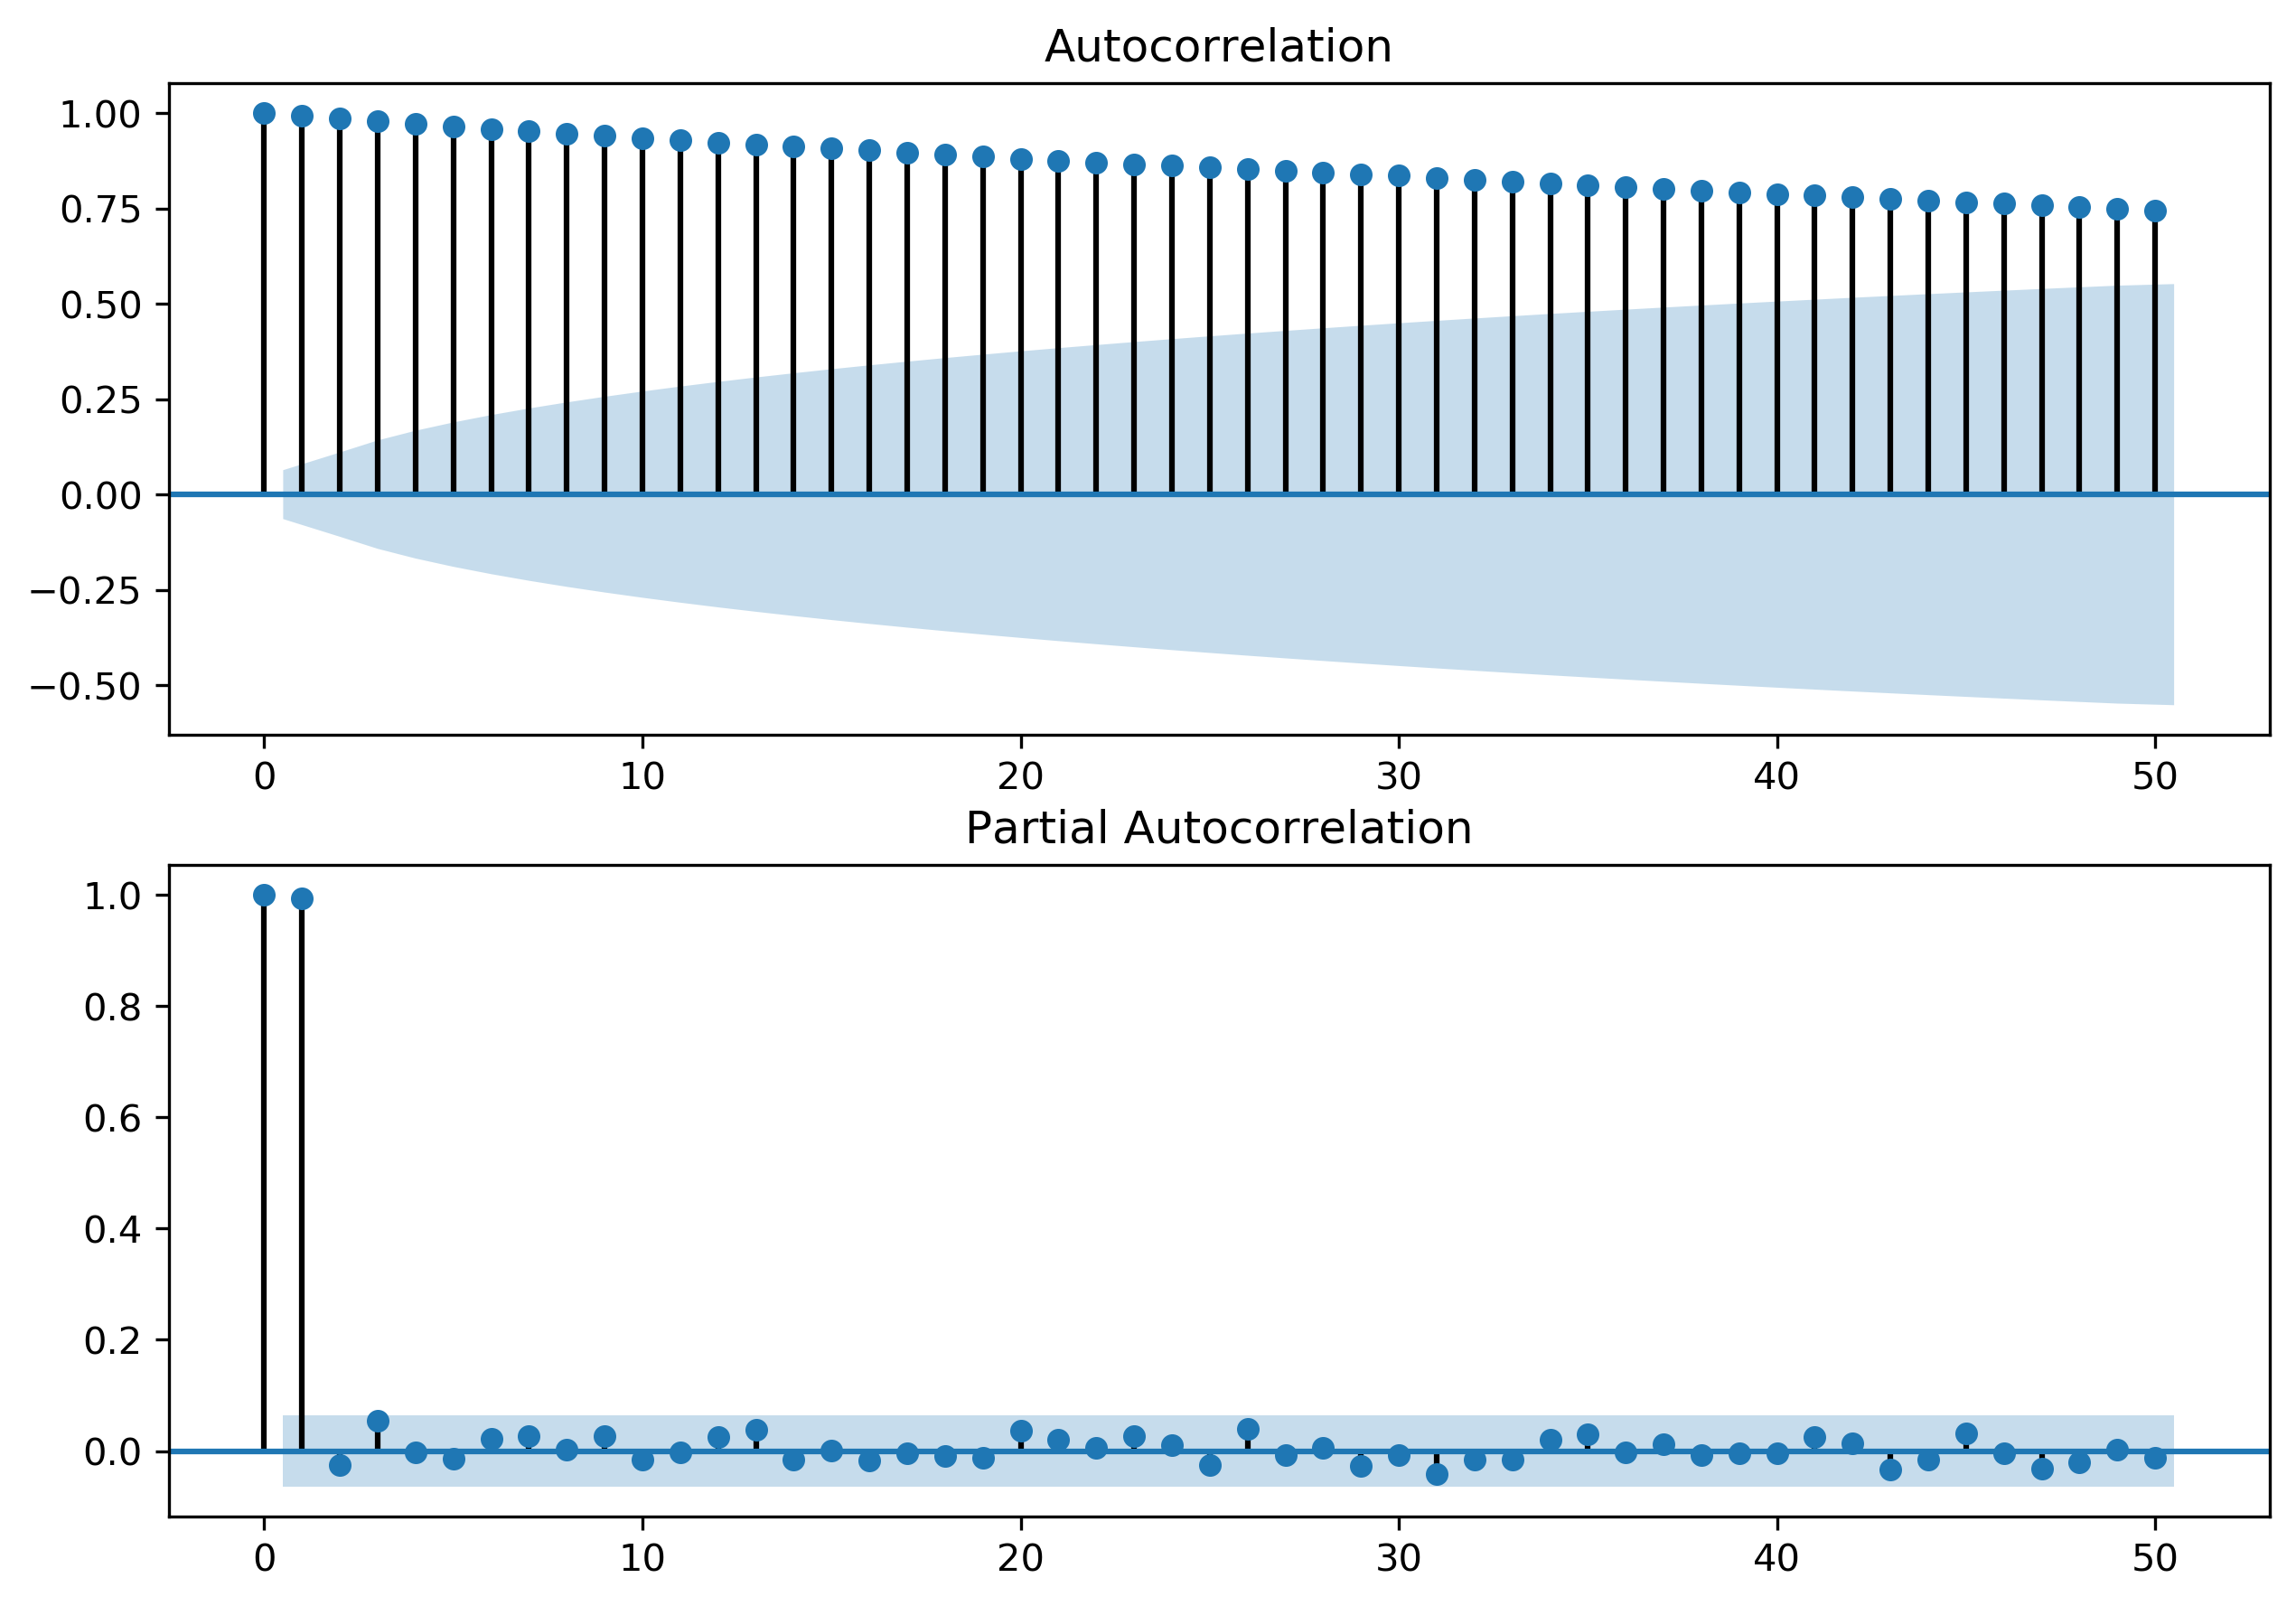

In [48]:
fig,ax= plt.subplots(2,1, figsize=(10,7), dpi=300)
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [49]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-6777.849, BIC=-6724.603, Fit time=1.387 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-6709.444, BIC=-6665.879, Fit time=0.556 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-6737.125, BIC=-6688.719, Fit time=0.859 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-6743.915, BIC=-6695.510, Fit time=1.196 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-6744.589, BIC=-6686.502, Fit time=1.786 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-6777.399, BIC=-6719.312, Fit time=1.667 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-6735.064, BIC=-6672.137, Fit time=3.188 seconds
Total fit time: 10.643 seconds


In [50]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  936
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3399.924
Date:                Tue, 12 May 2020   AIC                          -6777.849
Time:                        20:37:34   BIC                          -6724.603
Sample:                             0   HQIC                         -6757.545
                                - 936                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001   9.06e-05      1.427      0.154   -4.83e-05       0.000
x1            -0.1284      0.040     -3.239      0.001      -0.206      -0.051
x2            -0.0126      0.052     -0.243      0.808      -0.114       0.089
x3             0.0100      0.064      0.156      0.876      -0.115       0.135
x4             0.9085      0.084     10.830      0.000       0.744       1.073
x5             0.0017      0.006      0.281      0.779      -0.010       0.013
x6             0.0544      0.093      0.582      0.560      -0.129       0.237
x7            -0.0708      0.031     -2.259      0.024      -0.132      -0.009
ar.L1         -0.0579      0.082     -0.707      0.480      -0.218       0.103
ma.L1         -0.6049      0.072     -8.367      0.000      -0.747      -0.463
sigma2      4.055e-05   1.22e-06     33.194      0.000    3.82e-05    4.29e-05
===================================================================================
Ljung-Box (Q):                       44.62   Jarque-Bera (JB):               407.39
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.27
Prob(H) (two-sided):                  0.33   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.75e+16. Standard errors may be unstable.
"""

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
 exog=train_X,
 order=(1,1,1),
 enforce_invertibility=False, enforce_stationarity=False)

In [52]:
results = model.fit()

c:\users\emilo\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [53]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)

In [54]:
forecast_1= results.forecast(steps=test_size-1, exog=test_X)

In [55]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [56]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price next day']
predictions.rename(columns={0:'Pred'}, inplace=True)

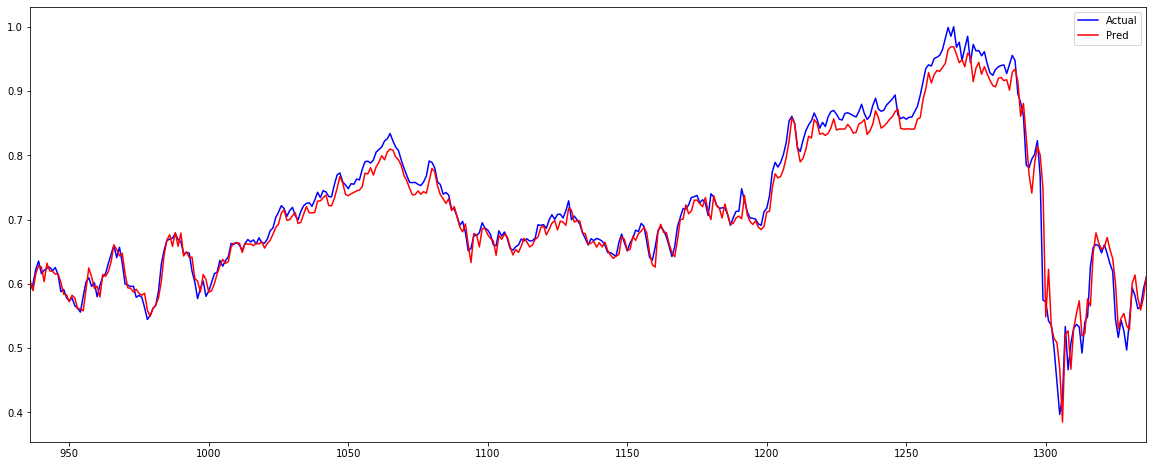

In [57]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))
fig.dpi=300

In [58]:
forecast_tatn= pd.DataFrame(forecast_1)
forecast_tatn.reset_index(drop=True, inplace=True)
forecast_tatn.index=test_X.index
forecast_tatn['Actual'] =scaler_output.iloc[train_size:, 0]
forecast_tatn.rename(columns={0:'Forecast'}, inplace=True)

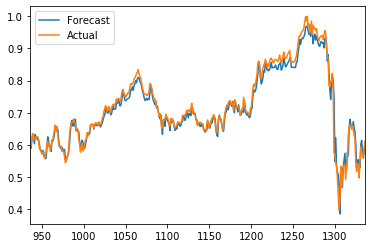

In [59]:
forecast_tatn['Forecast'].plot(legend=True)
forecast_tatn['Actual'].plot(legend=True)

In [60]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred'], predictions['Actual'])
error

0.020310084643574207

In [61]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['Actual']])